In [1]:
import sys 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid.inset_locator import inset_axes
sys.path.append('D:\PycQED')
from collections import OrderedDict as od
# from pycqed.analysis import measurement_analysis as MA 
# from pycqed.analysis import analysis_toolbox as a_tools
# import pycqed.analysis_v2.spectroscopy_analysis as ma2
# from pycqed.analysis import fitting_models as fit_mods
from scipy import constants
from scipy import optimize
import scipy
import math
import ipywidgets
import pandas as pd

import lmfit
import colorsys as colors
from IPython.display import display
# from nw_plotting_tools import *
# execfile('nw_figure_settings.py')
# savedir = 'D:\\Experiments\\1801_Holy_Chip\\Data_Figures\\'
# reload(MA)
# reload(a_tools)
%matplotlib inline
# print(savedir)

c:\users\tud278228\.virtualenvs\userenv-4qi24cvd\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
print(G.get_edge_data(*list(p)[0]))

NameError: name 'G' is not defined

In [ ]:
p = G.edges()
print(list(p)[0])


In [ ]:
N_channels = 1
print(np.eye(1,1,0))
np.diag(np.eye(1,2,1)[0])


In [ ]:
for n in G.nodes():
    print(n)

print(np.diagflat(1,-1))

0
(1, 2)
[[ 0. -1.]
 [-1.  0.]]
[[ 0. -1.]
 [-1.  0.]]


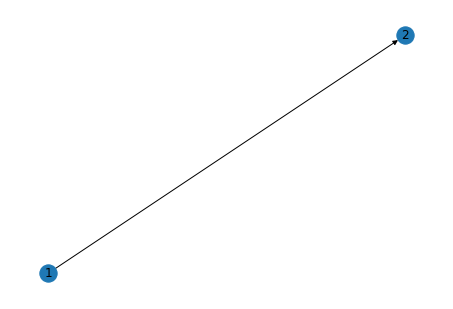

In [23]:
import numpy as np
def propagator(self,k,z):
    return np.exp(1j*k*z)
L = 4414.2e-6
short_dict = {'params':None,
                   'S_matrix':-1.,
              
                  }
segment_dict = {'params':'k',
                 'S_matrix':lambda k: propagator(k,z=L),
                 'values':{'length':L}
                }
G = nx.DiGraph()
G.add_node(1,**short_dict)
G.add_node(2,**short_dict)
G.add_edge(1, 2,**segment_dict,channel=0)
N_channels=1
S_ch = np.diag(np.eye(1,1,0)[0])
edge1 = list(G.edges)[0]
print(G.get_edge_data(*edge1)['channel'])
print(edge1)
n1,n2 = edge1
S_B = np.array([[0,G.node[n1]['S_matrix']],[G.node[n2]['S_matrix'],0]])
print(np.kron(S_ch,S_B))
print(S_B)
# G.get_edge_data(edge1)
# S_P = lambda k: 
nx.draw(G,with_labels = True)

In [24]:
print(G.nodes())
for n, S_matrix in G.nodes(data='S_matrix'):
    print(G.edges(n))

[1, 2]
[(1, 2)]
[]


In [25]:
from scipy.optimize import minimize
from scipy.linalg import null_space
import networkx as nx

# class chip:
#     # Resonator has an eigenmode chip doesnt
#     G = nx.DiGraph()
    
class resonator:
    # general mathematical functions
    ## values are know constants set by the user
    ## params are used for optimization to calculate the right value
    short_dict = {'params':None,
                       'S_matrix':-1.,
                      }
    open_dict = {'params':None,
                      'S_matrix':1.,
                      }
    
    def __init__(self):
        self.R = nx.DiGraph()
        self.N_channels = 0
        
    @staticmethod
    def capacitance_S_matrix(k,C,Phi0,Z0):
        return (1-1j*k*C*Phi0*Z0)/(1+1j*k*C*Phi0*Z0)
    
    @staticmethod
    def inductance_S_matrix(k,L,Phi0,Z0):
        return -(1-1j*k*L*Phi0/Z0)/(1+1j*k*L*Phi0/Z0)
    
    @staticmethod
    def basis(k,z):
        return np.array([np.exp(1j*k*z),np.exp(-1j*k*z)])
    
    @staticmethod
    def propagator(k,z):
        return np.array([[np.exp(-1j*k*z),0],[0,np.exp(-1j*k*z)]])
    

    def add_short(self, Anchor):
        self.R.add_node(Anchor, **self.short_dict)
        return self
    
    def add_inductive_short(self):
        pass
    
    def add_open(self, Anchor):
        self.R.add_node(Anchor, **self.open_dict)
        return self
    
    def add_capacitive_open(self, Anchor, C):
        capacitive_open_dict = {'params': 'k',
                                'values': {'C':C},
                                'S_matrix': self.capacitance_S_matrix}
        self.R.add_node(Anchor, **capacitive_open_dict)
        return self
        
    def add_inductive_short(self, Anchor, L):
        inductive_short_dict = {'params': 'k',
                                'values': {'L':L},
                                'S_matrix': self.inductance_S_matrix}
        self.R.add_node(Anchor, **inductive_short_dict)
        return self
        
    def add_segment(self,Anchors: tuple,
                    length: float, 
                    Z0: float = None, 
                    Phi0: float = None, 
                    lc: float = None, 
                    cc: float = None):
        self.length=length
        self.Phi0 = Phi0
        segment_dict = {'length':length,
                        'characteristic_values':{
                                    'Z0':Z0,
                                    'Phi0':Phi0}
                        }
        channel_nr = self.N_channels
        self.R.add_edge(*Anchors, **segment_dict,channel = channel_nr)
        self.R.node[Anchors[0]]['channel'] = channel_nr
        self.R.node[Anchors[1]]['channel'] = channel_nr
        self.N_channels += 1
        return self
    
    def _get_scattering_matrix(self):
        #loop over nodes
            #extract the scattering matrix
            #extract the channel number
            #tensor product the two
            #Add to the scattering matrix
        
        def S_B_matrix(k):
            S_B = np.zeros((2*self.N_channels,2*self.N_channels),dtype=np.complex128)
            for n in self.R.nodes():
                node_data = self.R.node[n]
                Ch_node = node_data['channel']
                S_ch = np.diag(np.eye(1,self.N_channels,Ch_node)[0])
                for e in self.R.in_edges(n):
                    e_data = self.R.get_edge_data(*e)
                    S_node = node_data['S_matrix']
                    if callable(S_node):
                        S_matrix_node = S_node(k,**node_data['values'],**e_data['characteristic_values'])
                    else:
                        S_matrix_node = S_node
                    S_B1 = np.diagflat(1,1)*S_matrix_node
                    S = np.kron(S_ch,S_B1)
                    S_B += S

                for e in self.R.out_edges(n):
                    e_data = self.R.get_edge_data(*e)
                    S_node = node_data['S_matrix']
                    if callable(S_node):
                        S_matrix_node = S_node(k,**node_data['values'],**e_data['characteristic_values'])
                    else:
                        S_matrix_node = S_node
                    S_B2 = np.diagflat(1,-1)*S_matrix_node
                    S = np.kron(S_ch,S_B2)
                    S_B += S
            return S_B
        return S_B_matrix

    def _get_propagation_matrix(self):
        #loop over edges
            #extract channel number
            #construct propagation matrix
            #tensor product the two
            # add to the propagation matrix
        
        def P_matrix(k):
            S_P = np.zeros((2*self.N_channels,2*self.N_channels),dtype=np.complex128)
            for e in self.R.edges():
                e_data = self.R.get_edge_data(*e)
                e_channel = e_data['channel']
                length = e_data['length']
                S_P = self.propagator(k,length)
                S_ch = np.diag(np.eye(1,self.N_channels,e_channel)[0])
                S = np.kron(S_ch,S_P)
            return S
        return P_matrix
            
            
            
            
            
            
    def get_eigenmode(self):
        guess = self.get_mode_guess('k')
        self.S_B = self._get_scattering_matrix()
        self.S_P = self._get_propagation_matrix()
        def mode_condition(k):
            if type(k) == np.ndarray:
                k = k[0]
            mode_condition = np.linalg.det(np.subtract(np.eye(2),np.matmul(self.S_B(k),self.S_P(k))))
            return mode_condition
            
        result = minimize(mode_condition,guess)

        self.k_res = abs(result['x'][0])
        self.omega_res = self.k_res*self.Phi0
        self.f_res = self.omega_res/2/np.pi
#         self.tolerance = result
        return self.k_res, self.f_res
    
    def get_eigenfunction(self):
        k_res = self.k_res
        T = np.matmul(self.S_B(k_res),self.S_P(k_res))
        self.eigenfunction_coefficients = null_space(np.subtract(np.eye(2),T),rcond=1e-3)[:,0]
        #calculate nullspace
        def eigenfunction(z):
            return list(map(lambda zv: np.sum(self.eigenfunction_coefficients*self.basis(k_res,zv)),z))

        return eigenfunction
    
    #helper functions
    def get_mode_guess(self,params):
        if params == 'k':
            return 2*np.pi/4/self.length
        else:
            raise NotImplementedError('Parameter %s is not implemented yet'%(self.params))
        


<function resonator._get_scattering_matrix.<locals>.S_B_matrix at 0x000001626821AB70>
(21.674182725164258, 331157118.54593843)


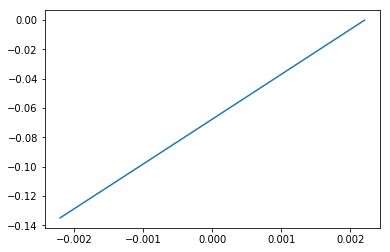

In [46]:
import matplotlib.pyplot as plt 
%matplotlib inline
q1_params = {'Z0':50,
             'Phi0':0.96e8,
             'lc':None,
             'cc':None}
L = 4414e-6
# reso1 = (resonator()
#       .add_short('B')#,L=1e-)
#       .add_capacitive_open('B',C=25e-15)
#       .add_segment(('A','B'), length = L, **q1_params)
# )

reso1 = (resonator()
      .add_capacitive_open('B',C=100000e-15)
      .add_short('A')
      .add_segment(('B','A'), length = L, **q1_params)
)
print(reso1._get_scattering_matrix())
prop_fun = reso1._get_propagation_matrix()
print(reso1.get_eigenmode())
eigenfunc = reso1.get_eigenfunction()
zvals = np.linspace(-L/2,L/2,100)
plt.plot(zvals,np.imag(eigenfunc(zvals)))


In [27]:
np.array([[np.exp(1j*1.51),0],[0,np.exp(1j*1.51)]])

array([[ 0.06075888+0.99815247j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        ,  0.06075888+0.99815247j]])

In [28]:
for n in reso1.R.nodes():
    print('node: ',n)
    node_data = reso1.R.node[n]
    print('S_matrix',node_data['S_matrix']*np.diagflat(1,1))

node:  B


TypeError: unsupported operand type(s) for *: 'function' and 'int'

In [13]:
T = np.array([[ 0.00000000e+00+0.j, -4.76920608e-05-1.j],[ 4.76920608e-05+1.j,  0.00000000e+00+0.j]])
nul = np.subtract(np.eye(2),T)
print(nul)
nul2 = np.array([[ 1, 1],[ 1,  1]])
print(nul2)
eigenfunction_coefficients = null_space(np.array(nul2),rcond=1e-3)[:,0]
print(eigenfunction_coefficients)

[[  1.00000000e+00+0.j   4.76920608e-05+1.j]
 [ -4.76920608e-05-1.j   1.00000000e+00+0.j]]
[[1 1]
 [1 1]]
[-0.70710678  0.70710678]


In [14]:
reso1.basis(reso1.k_res,zvals[1])

AttributeError: 'resonator' object has no attribute 'k_res'

In [15]:
modevals = [np.sum(eigenfunction_coefficients*reso1.basis(reso1.k_res,zv)) for zv in zvals]
plt.plot(zvals,np.absolute(modevals))

NameError: name 'zvals' is not defined

In [16]:
plotfn = q1.get_eigenfunction()
z_vals = np.linspace(0,-L,100)
# [print(x) for x in list(map(lambda x: q1.propagator(711,x),z_vals))]
print(plotfn(z_vals))
plt.plot(z_vals,plotfn(z_vals))
# plotfn(z_vals)

NameError: name 'q1' is not defined

In [17]:
T  = np.array([[-0.7259323+0.68776616j,0.+0.j],
                [0.+0.j,-0.7259323-0.68776616j]])
np.linalg.det(T)
1423.19931396*0.96e8

136627134140.15999

In [18]:
null_space(np.eye(2)-np.eye(2))

array([[ 1.,  0.],
       [ 0.,  1.]])

In [19]:
A = [[1.-2.38055826e-08j, 0],
 [0, 1.+2.38055826e-08j]]
B = np.eye(2)-A

In [20]:
null_space(B,rcond=1)

array([[-1.-0.j, -0.-0.j],
       [-0.-0.j, -1.-0.j]])

In [21]:
np.matrix([[np.exp(1j*711*L),0],[0,np.exp(-1j*711*L)]])

matrix([[-0.99999476+0.00323865j,  0.00000000+0.j        ],
        [ 0.00000000+0.j        , -0.99999476-0.00323865j]])